In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import sys
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**STL10** Dataset

In [4]:
def load_stl10_datasets(transform=None):
    # Load STL10 train dataset
    dataset = torchvision.datasets.STL10(
        root='.', 
        split='train+unlabeled', 
        download=True, 
        transform=transform
    )


    return dataset

In [5]:
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])
dataset = load_stl10_datasets(transform)

100%|██████████| 2640397119/2640397119 [01:58<00:00, 22264086.14it/s]


Extracting ./stl10_binary.tar.gz to .


In [6]:
batchsize   = 128

In [7]:
data_loader = DataLoader(dataset,batch_size=batchsize,shuffle=True,drop_last=True)

In [8]:
len(dataset)

105000

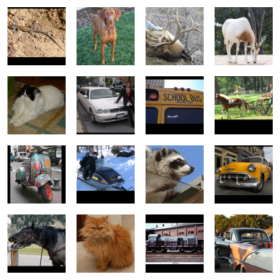

In [9]:
X,y = next(iter(data_loader))

fig,axs = plt.subplots(4,4,figsize=(4,4))

for (i,ax) in enumerate(axs.flatten()):


  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5
  label = dataset.classes[y[i]]


  ax.imshow(pic)
  ax.axis('off')

plt.tight_layout()
plt.show()

# GAN Discriminator

In [10]:
class discriminatorNetw(nn.Module):
  def __init__(self):
    super().__init__()

    
    self.conv1 = nn.Conv2d(  3, 64, 4, stride=2, padding=1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, stride=2, padding=1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, stride=2, padding=1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 3, stride=2, padding=0, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, stride=2, padding=0, bias=False)

    
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)
    
  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


disc_net = discriminatorNetw()

# GAN Generator

In [11]:
class generatorNetw(nn.Module):
  def __init__(self):
    super().__init__()

    
    self.conv1 = nn.ConvTranspose2d(100,512, 4, stride=2, padding=0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, stride=2, padding=0, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, stride=2, padding=0, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=0, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   3, 6, stride=2, padding=0, bias=False)

    
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x
    

gen_net = generatorNetw()

**Loss Function, Data Parallel, Optimizer**

In [12]:
lossfun = nn.BCELoss()

disc_net = discriminatorNetw().to(device)
gen_net = generatorNetw().to(device)


if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    disc_net = nn.DataParallel(disc_net)
    gen_net = nn.DataParallel(gen_net)


disc_net.to(device)
gen_net.to(device)

disc_optimizer = torch.optim.Adam(disc_net.parameters(), lr=.0002, betas=(.5, .999))
gen_optimizer = torch.optim.Adam(gen_net.parameters(), lr=.0002, betas=(.5, .999))

Using 2 GPUs!


**Training**

In [13]:
num_epochs = 50
losses  = []
disc_loss = []
genr_loss = []


for epochi in range(num_epochs):
  for data,_ in data_loader:

    data = data.to(device)

    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)

    #discriminator part
    pred_real   = disc_net(data)                     # output
    d_loss_real = lossfun(pred_real,real_labels)


    fake_data   = torch.randn(batchsize,100,1,1).to(device)
    fake_images = gen_net(fake_data)                           # output of gen
    pred_fake   = disc_net(fake_images)
    d_loss_fake = lossfun(pred_fake,fake_labels)


    d_loss = d_loss_real + d_loss_fake


    disc_optimizer.zero_grad()
    d_loss.backward()
    disc_optimizer.step()


    #generator part
    fake_images = gen_net( torch.randn(batchsize,100,1,1).to(device) )
    pred_fake   = disc_net(fake_images)

    g_loss = lossfun(pred_fake,real_labels)

    gen_optimizer.zero_grad()
    g_loss.backward()
    gen_optimizer.step()

    losses.append([d_loss.item(),g_loss.item()])


  print(f'Epoch [{epochi+1}/{num_epochs}], Discriminator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}')
  disc_loss.append(d_loss.item())
  genr_loss.append(g_loss.item())

losses  = np.array(losses)

Epoch [1/50], Discriminator Loss: 0.3345422148704529, Generator Loss: 3.074462652206421
Epoch [2/50], Discriminator Loss: 0.5509897470474243, Generator Loss: 3.9677679538726807
Epoch [3/50], Discriminator Loss: 0.7471910715103149, Generator Loss: 0.8399850130081177
Epoch [4/50], Discriminator Loss: 0.15132981538772583, Generator Loss: 1.7009168863296509
Epoch [5/50], Discriminator Loss: 0.5660925507545471, Generator Loss: 5.758650779724121
Epoch [6/50], Discriminator Loss: 0.1692509949207306, Generator Loss: 3.7286858558654785
Epoch [7/50], Discriminator Loss: 0.17854943871498108, Generator Loss: 2.9538016319274902
Epoch [8/50], Discriminator Loss: 0.11035653948783875, Generator Loss: 5.284700870513916
Epoch [9/50], Discriminator Loss: 0.10704789310693741, Generator Loss: 3.917496681213379
Epoch [10/50], Discriminator Loss: 0.0905986800789833, Generator Loss: 3.611353874206543
Epoch [11/50], Discriminator Loss: 0.5762608647346497, Generator Loss: 9.705224990844727
Epoch [12/50], Discri

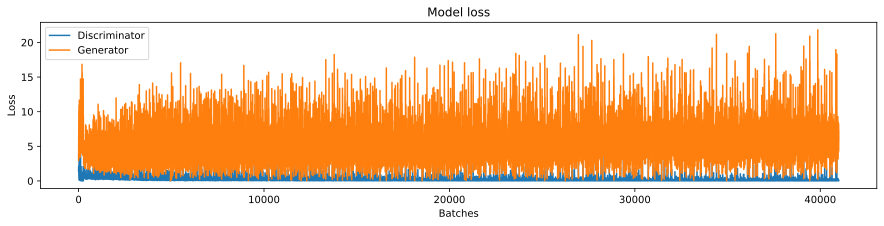

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.plot(losses[:, 0])
plt.plot(losses[:, 1])
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend(['Discriminator', 'Generator'])
plt.show()

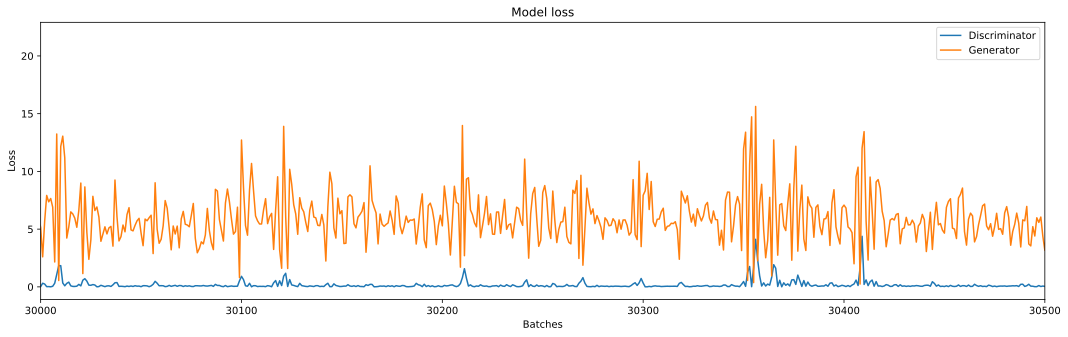

In [31]:
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(losses[:, 0])
ax.plot(losses[:, 1])
ax.set_xlabel('Batches')
ax.set_ylabel('Loss')
ax.set_title('Model loss')
ax.legend(['Discriminator', 'Generator'])
ax.set_xlim([30000, 30500])
plt.show()

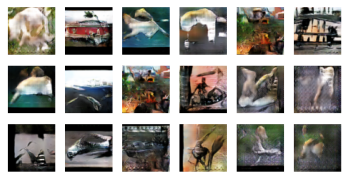

In [22]:
gen_net.eval()
fake_data = gen_net( torch.randn(batchsize,100,1,1).to(device) ).cpu()
fig,axs = plt.subplots(3,6,figsize=(6,3))
for i,ax in enumerate(axs.flatten()):
  pic = fake_data[i,:,].detach().squeeze().numpy().transpose((1,2,0))
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  ax.imshow(pic)
  ax.axis('off')

plt.show()

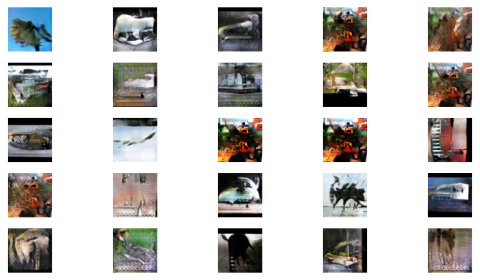

In [21]:
gen_net.eval()
fake_data = gen_net( torch.randn(batchsize,100,1,1).to(device) ).cpu()
fig,axs = plt.subplots(5,5,figsize=(8,4))
for i,ax in enumerate(axs.flatten()):
  pic = fake_data[i,:,].detach().squeeze().numpy().transpose((1,2,0))
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  ax.imshow(pic)
  ax.axis('off')
plt.savefig('output_images.png', dpi=300)
plt.tight_layout()
plt.show()